In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../../WNTR_Model/')
from testWN import testWN as twm

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['font.size'] = 16
mpl.rcParams['figure.figsize'] = (10,6)

# Data Preprocessing:

In [4]:
# file = 'surrModel_TrainingDB_inp.pkl'
# with open(file, 'rb') as f:
#     training_in = pickle.load(f)
    
# file = 'surrModel_TrainingDB_out.pkl'
# with open(file, 'rb') as f:
#     training_out = pickle.load(f)
    
file = 'surrModel_trainingDB_uF0p00.pkl'
with open(file, 'rb') as f:
    train_data = pickle.load(f)
training_in = train_data['input']
training_out = train_data['output']

In [5]:
input_names = {}
input_names_raw = training_in.keys().to_list()

output_names = {}
output_names_raw = training_out.keys().to_list()

input_names['demand'] = [name_i for name_i in input_names_raw if name_i.startswith('J')]
input_names['pumps'] = [name_i for name_i in input_names_raw if name_i.startswith('PU')]
input_names['valves'] = [name_i for name_i in input_names_raw if name_i.startswith('V')]
input_names['tanks'] = [name_i for name_i in input_names_raw if name_i.startswith('T')]

output_names['pressure'] = [name_i for name_i in output_names_raw if name_i.startswith('J')]
output_names['tanks'] = [name_i for name_i in output_names_raw if name_i.startswith('T')]
output_names['power'] = [name_i for name_i in output_names_raw if name_i.startswith('PU')]

## Check Data and filter

``data_filter`` holds a ``bool`` for every entry of the data matrices. It is set to zero if any of the conditions are not satisfied. All data is filtered in the end to exclude faulty values.

In [6]:
data_filter = np.ones(training_in.shape[0], dtype=bool)

### Junctions:
Pressure and demand.

In [7]:
junction_demand = training_in[input_names['demand']]
junction_pressure = training_out[output_names['pressure']]

<AxesSubplot:title={'center':'pressure'}, xlabel='time [h]', ylabel='pressure [m]'>

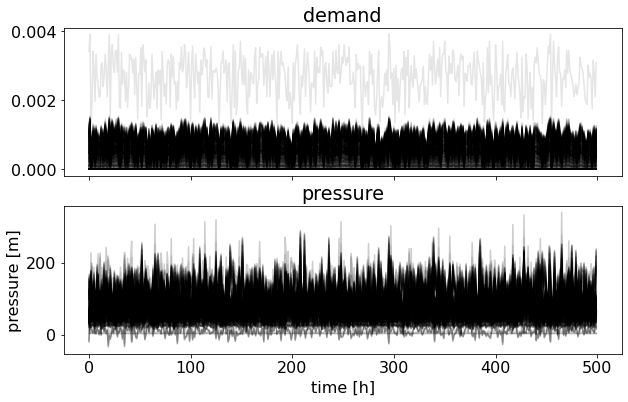

In [8]:
fig, ax = plt.subplots(2,1, sharex=True)
junction_demand.head(500).plot(ax=ax[0],legend=False, color='k', alpha=0.1, title='demand', xlabel='time [h]')
junction_pressure.head(500).plot(ax=ax[1],legend=False, color='k', alpha=0.1, title='pressure', xlabel='time [h]', ylabel='pressure [m]')

In [9]:
#data_filter = data_filter & np.all(np.abs(junction_pressure)<1e3, axis=1)
#data_filter = data_filter & np.all(junction_pressure>0, axis=1)

After filtering:

<AxesSubplot:title={'center':'pressure'}, xlabel='time [h]', ylabel='pressure [m]'>

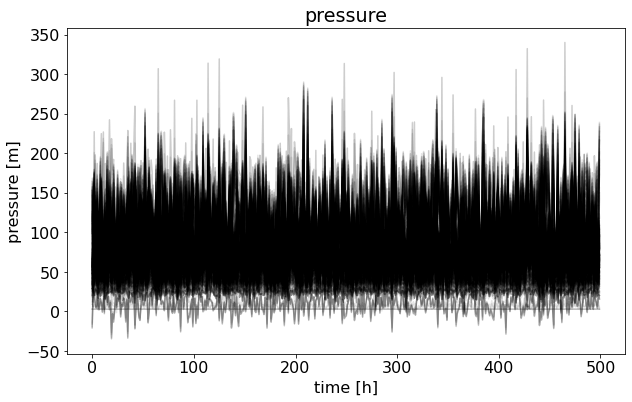

In [10]:
junction_pressure[data_filter].head(500).plot(legend=False, color='k', alpha=0.1, title='pressure', xlabel='time [h]', ylabel='pressure [m]')

### Tank levels:

<AxesSubplot:title={'center':'delta tank levels'}, xlabel='time [h]', ylabel='delta height [m]'>

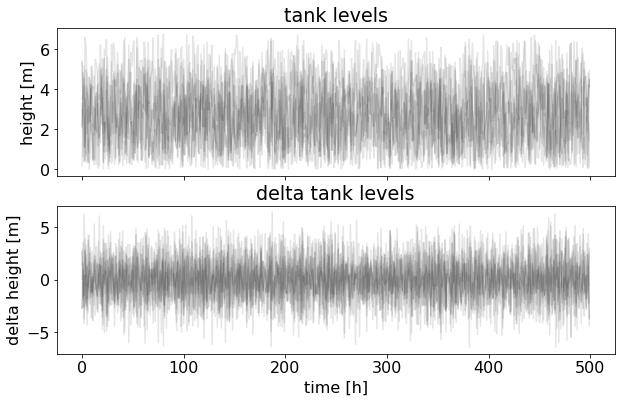

In [11]:
fig, ax = plt.subplots(2,1, sharex = True)
tank_level = training_in[input_names['tanks']]
dtank_level = training_out[output_names['tanks']]
tank_level.head(500).plot(ax=ax[0],legend=False, color='k', alpha=0.1, title='tank levels', xlabel='time [h]', ylabel='height [m]')
dtank_level.head(500).plot(ax=ax[1],legend=False, color='k', alpha=0.1, title='delta tank levels', xlabel='time [h]', ylabel='delta height [m]')

### Pumps:

<AxesSubplot:title={'center':'pump setting'}, xlabel='time [h]', ylabel='setting'>

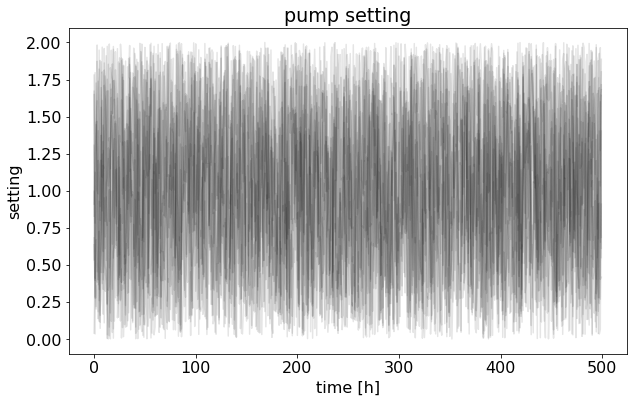

In [12]:
pump_setting = training_in[input_names['pumps']]
pump_setting.head(500).plot(legend=False, color='k', alpha=0.1, title='pump setting', xlabel='time [h]', ylabel='setting')

<AxesSubplot:title={'center':'pump power'}, xlabel='time [h]', ylabel='power'>

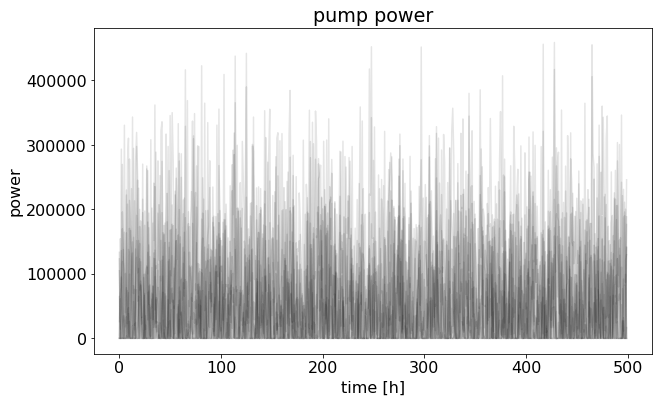

In [13]:
pump_power = training_out[output_names['power']]
pump_power.head(500).plot(legend=False, color='k', alpha=0.1, title='pump power', xlabel='time [h]', ylabel='power')

In [14]:
#data_filter = data_filter & np.all(np.abs(pump_power)<1e6,axis=1) & np.all(pump_power>=0, axis=1)

After filtering:

<AxesSubplot:title={'center':'pump power'}, xlabel='time [h]', ylabel='power'>

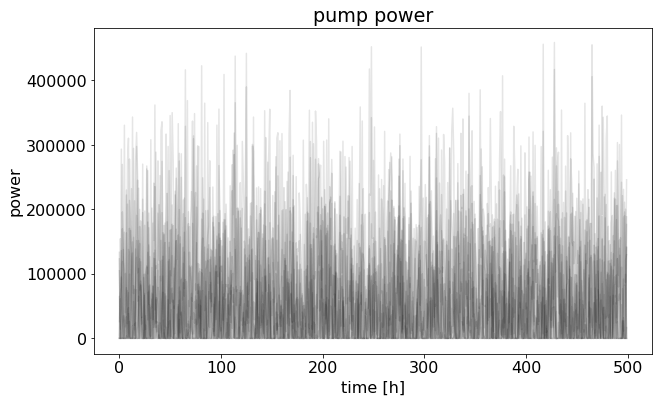

In [15]:
pump_power[data_filter].head(500).plot(legend=False, color='k', alpha=0.1, title='pump power', xlabel='time [h]', ylabel='power')

Let's check the pump_power vs pump_setting after filtering:

Text(0.5, 1.0, 'pump setting vs. power consumption')

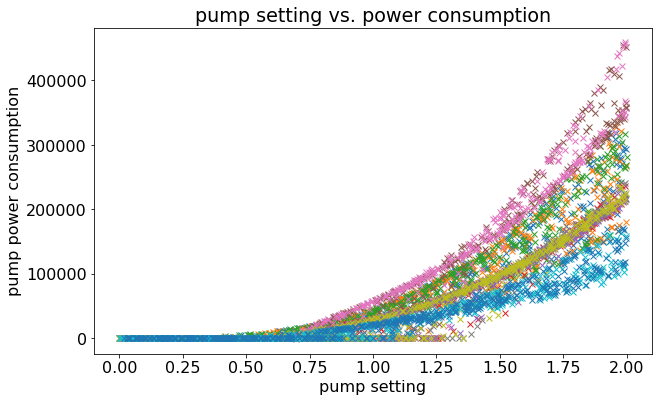

In [16]:
fig, ax = plt.subplots()
ax.plot(pump_setting[data_filter].head(500).to_numpy(), pump_power[data_filter].head(500).to_numpy(), 'x')
ax.set_xlabel('pump setting')
ax.set_ylabel('pump power consumption')
ax.set_title('pump setting vs. power consumption')

### Valves

<AxesSubplot:title={'center':'valve settting'}, xlabel='time [h]', ylabel='setting'>

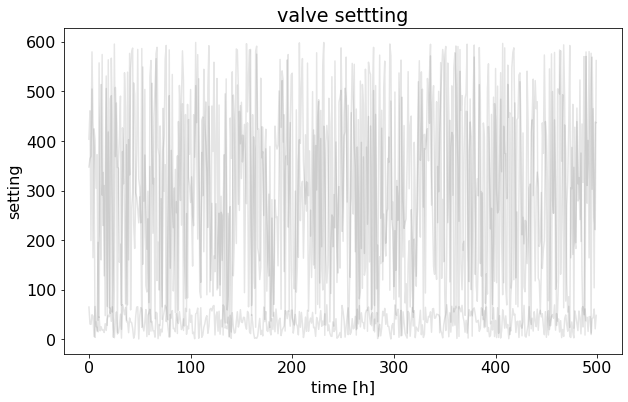

In [17]:
valve_setting = training_in[input_names['valves']]

valve_setting.head(500).plot(legend=False, color='k', alpha=0.1, title='valve settting', xlabel='time [h]', ylabel='setting')

## Neural Network Pre-Processing
### NN inputs:

In [30]:
input_1_dict = {
    'junction_demand': junction_demand[data_filter]
}
nn_inputs_1 = pd.concat(input_1_dict.values(), axis=1, keys=input_1_dict.keys())

input_2_dict = {
    'tank_level': tank_level[data_filter],
}
nn_inputs_2 = pd.concat(input_2_dict.values(), axis=1, keys=input_2_dict.keys())

input_3_dict = {
    'pump_setting': pump_setting[data_filter],                   
    'valve_setting': valve_setting[data_filter]
}
nn_inputs_3 = pd.concat(input_3_dict.values(), axis=1, keys=input_3_dict.keys())

nn_input_dict = {
    'demand': nn_inputs_1,
    'states': nn_inputs_2,
    'inputs': nn_inputs_3,
}
nn_input = pd.concat(nn_input_dict.values(), axis=1, keys=nn_input_dict.keys())

nn_input.head(2)

demand                                                            \
  junction_demand                                                             
           J511_d    J411_d    J414_d J415_d J416_d    J417_d J418_d J419_d   
0        0.000954  0.000595  0.000646    0.0    0.0  0.000864    0.0    0.0   
1        0.001093  0.000804  0.000874    0.0    0.0  0.001168    0.0    0.0   

                      ...       inputs                                \
                      ... pump_setting                                 
     J310_d   J311_d  ...          PU5       PU6       PU7       PU8   
0  0.000965  0.00084  ...     0.828221  0.635555  0.682839  0.996615   
1  0.001264  0.00110  ...     1.796456  0.410246  0.282316  0.034120   

                                                                      
                                valve_setting                         
        PU9      PU10      PU11           V45         V47         V2  
0  1.648176  1.779836  1.670622    403.597614  347.491838  65.124736  
1  0.781200  0.397895  0.273652    460.851002  364.256565  30.927736  

[2 rows x 409 columns]

In [31]:
nn_input.shape

(100000, 409)

### NN outputs:

In [32]:
#dtank_level = tank_level[data_filter].diff(axis=0)
#dtank_level_next = dtank_level.shift(-1, axis=0)
dtank_level_next = dtank_level[data_filter]

output_1_dict ={
    'junction_pressure': junction_pressure[data_filter],
}
nn_outputs_1 = pd.concat(output_1_dict.values(), axis=1, keys=output_1_dict.keys())

output_2_dict = {
    'pump_power': pump_power[data_filter],
}
nn_outputs_2 = pd.concat(output_2_dict.values(), axis=1, keys=output_2_dict.keys())

output_3_dict = {
    'dtank_level_next': dtank_level_next,
}
nn_outputs_3 = pd.concat(output_3_dict.values(), axis=1, keys=output_3_dict.keys())

nn_output_dict = {
    'pressure': nn_outputs_1,
    'energy': nn_outputs_2,
    'dstates': nn_outputs_3,
}
nn_output = pd.concat(nn_output_dict.values(), axis=1, keys=nn_output_dict.keys())

nn_output.head(2)

pressure                                                         \
  junction_pressure                                                          
             J511_p     J411_p     J414_p     J415_p     J416_p     J417_p   
0         29.263010  61.055279  35.380035  59.967506  82.341919  32.290325   
1         26.043179  67.791718  38.970432  52.669376  75.069374  34.882030   

                                               ...         energy  \
                                               ...     pump_power   
      J418_p     J419_p     J310_p     J311_p  ...          PU9_P   
0  31.883665  29.054243  78.672646  74.591942  ...  133417.771748   
1  30.607012  27.254971  46.318008  42.256321  ...   14175.420237   

                                         dstates                      \
                                dtank_level_next                       
          PU10_P         PU11_P        T3_change T1_change T7_change   
0  123340.760819  104875.294779        -2.692077  1.476910  2.654936   
1       0.000000       0.000000        -2.271071  1.582415 -1.679070   

                                           
                                           
  T6_change T5_change T2_change T4_change  
0  0.043300  2.890177 -2.651978 -2.656805  
1  0.980108 -1.914823 -0.196165  3.531496  

[2 rows x 406 columns]

# ACHTUNG ENTFERNEN:

In [59]:
#nn_output['dstates'] = 0
#nn_output['pressure'] = 0
#nn_output['dstates'].head(5)

dtank_level_next                                                            
         T3_change T1_change T7_change T6_change T5_change T2_change T4_change
0                0         0         0         0         0         0         0
1                0         0         0         0         0         0         0
2                0         0         0         0         0         0         0
3                0         0         0         0         0         0         0
4                0         0         0         0         0         0         0

Filter inputs and outputs. Due to shifting, we introduced `NaN` in the dataframes. These are removed in this step.

In [60]:
# Filter nan:
output_filter = nn_output.isnull().any(axis=1)
if output_filter.any():
    nn_input = nn_input[~output_filter]
    nn_output = nn_output[~output_filter]
    

input_filter = nn_input.isnull().any(axis=1)
if input_filter.any():
    nn_input = nn_input[~input_filter]
    nn_output = nn_output[~input_filter]

print('n_samples={}, n_inputs = {}, n_outputs={}'.format(*nn_input.shape, nn_output.shape[1]))

n_samples=100000, n_inputs = 409, n_outputs=406


In [61]:
input_scaling = nn_input.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_scaled = nn_input/input_scaling

output_scaling = nn_output.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_scaled = nn_output/output_scaling

# DNN Model creation

Create model architecture with input to condense the demand and then input for states control inputs etc.

In [62]:
UnitNorm_cons = tf.keras.constraints.UnitNorm(axis=1)
minmax_cons = tf.keras.constraints.MinMaxNorm(
    min_value=0, max_value=1.0, rate=1.0, axis=1
)
nonneg_cons = tf.keras.constraints.NonNeg()
#nonnegunit_cons =  nonnegUnitNorm(axis=1)

l1_penalty = tf.keras.regularizers.l1(l=0.001)
l2_penalty = tf.keras.regularizers.l2(l=0.1)

In [63]:
n_cluster = 40
n_layer = 4
n_neurons_per_layer = 60

# Input 1 with reduction:
tf_in_1 = tf.keras.Input(shape=(nn_input['demand'].shape[1]), name='demand_in')
tf_in_1_red = tf.keras.layers.Dense(
    n_cluster, 
    name='cluster_demand', 
    use_bias=False,
    #activation=tf.nn.tanh,
    #kernel_regularizer=l1_penalty,
    #kernel_constraint=UnitNorm_cons,
)(tf_in_1)

# Input 2 & 3
tf_in_2 = tf.keras.Input(shape=(nn_input['states'].shape[1],), name='states_in')
tf_in_3 = tf.keras.Input(shape=(nn_input['inputs'].shape[1],), name='inputs_in')

# Concatenating inputs:
tf_in_cat = tf.keras.layers.concatenate([tf_in_1_red, tf_in_2, tf_in_3], name='input_concatenate')

# Intermediate (non-linear) layers:
for i in range(n_layer):
    if i == 0:
        tf_interm = tf.keras.layers.Dense(n_neurons_per_layer, activation=tf.nn.relu, name='interm_'+str(i))(tf_in_cat)
    else:
        tf_interm = tf.keras.layers.Dense(n_neurons_per_layer, activation=tf.nn.relu, name='interm_'+str(i))(tf_interm)

# splitting:
tf_interm_1 = tf_interm[:,:n_cluster]
tf_interm_2 = tf_interm[:,n_cluster:]

# Linear output layer
tf_out_1 = tf.keras.layers.Dense(
    nn_output['pressure'].shape[1], 
    name='pressure_out', 
    use_bias=False,
    #kernel_constraint=nonneg_cons,
    #kernel_regularizer = l1_penalty,
)(tf_interm_1)

tf_out_2 = tf.keras.layers.Dense(nn_output['energy'].shape[1], name='energy_out')(tf_interm_2)
tf_out_3 = tf.keras.layers.Dense(nn_output['dstates'].shape[1], name='dstates_out')(tf_interm_2)


In [64]:
model = tf.keras.Model(inputs=[tf_in_1, tf_in_2, tf_in_3], outputs=[tf_out_1,tf_out_2, tf_out_3])

In [65]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=optim, loss='mse')

# Achtung entfernen:

In [66]:
#nn_input_scaled = nn_input_scaled.head(1000)
#nn_output_scaled = nn_output_scaled.head(1000)

## Model training

In [67]:
history = model.fit([nn_input_scaled['demand'], nn_input_scaled['states'], nn_input_scaled['inputs']], 
                    [nn_output_scaled['pressure'], nn_output_scaled['energy'], nn_output_scaled['dstates']], 
                    batch_size=100, 
                    epochs=1000)

Epoch 1/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.1006 - pressure_out_loss: 0.0028 - energy_out_loss: 0.0899 - dstates_out_loss: 0.0079
Epoch 2/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0803 - pressure_out_loss: 8.1733e-04 - energy_out_loss: 0.0732 - dstates_out_loss: 0.0062
Epoch 3/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0708 - pressure_out_loss: 2.5422e-04 - energy_out_loss: 0.0666 - dstates_out_loss: 0.0040
Epoch 4/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0628 - pressure_out_loss: 2.5975e-04 - energy_out_loss: 0.0600 - dstates_out_loss: 0.0026
Epoch 5/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0584 - pressure_out_loss: 1.1896e-04 - energy_out_loss: 0.0564 - dstates_out_loss: 0.0019
Epoch 6/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0553 - pressure_out_loss: 6.5950e-05 - energy_out_loss: 0.0534 - dstates_out_loss: 0.0018
Epoch 7/

10/10 [==============================] - 0s 1ms/step - loss: 0.0184 - pressure_out_loss: 2.9572e-08 - energy_out_loss: 0.0175 - dstates_out_loss: 8.6989e-04
Epoch 50/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0176 - pressure_out_loss: 5.4006e-08 - energy_out_loss: 0.0168 - dstates_out_loss: 8.5828e-04
Epoch 51/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0170 - pressure_out_loss: 3.4675e-08 - energy_out_loss: 0.0162 - dstates_out_loss: 8.5198e-04
Epoch 52/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0167 - pressure_out_loss: 3.0097e-08 - energy_out_loss: 0.0159 - dstates_out_loss: 8.0199e-04
Epoch 53/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0165 - pressure_out_loss: 3.9395e-08 - energy_out_loss: 0.0157 - dstates_out_loss: 7.9273e-04
Epoch 54/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0160 - pressure_out_loss: 4.2574e-08 - energy_out_loss: 0.0152 - dstates_out_loss:

Epoch 97/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0079 - pressure_out_loss: 2.0117e-08 - energy_out_loss: 0.0077 - dstates_out_loss: 1.6512e-04
Epoch 98/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0078 - pressure_out_loss: 9.7009e-09 - energy_out_loss: 0.0076 - dstates_out_loss: 1.5940e-04
Epoch 99/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0078 - pressure_out_loss: 4.8977e-09 - energy_out_loss: 0.0077 - dstates_out_loss: 1.5816e-04
Epoch 100/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0077 - pressure_out_loss: 1.6554e-09 - energy_out_loss: 0.0076 - dstates_out_loss: 1.6325e-04
Epoch 101/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0077 - pressure_out_loss: 1.7896e-08 - energy_out_loss: 0.0075 - dstates_out_loss: 1.5586e-04
Epoch 102/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0077 - pressure_out_loss: 2.3323e-08 - energy_out_loss: 0.0075 - 

10/10 [==============================] - 0s 1ms/step - loss: 0.0046 - pressure_out_loss: 5.7887e-09 - energy_out_loss: 0.0045 - dstates_out_loss: 1.0329e-04
Epoch 145/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0045 - pressure_out_loss: 3.6519e-09 - energy_out_loss: 0.0044 - dstates_out_loss: 9.8008e-05
Epoch 146/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0044 - pressure_out_loss: 5.8163e-09 - energy_out_loss: 0.0043 - dstates_out_loss: 9.9106e-05
Epoch 147/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0044 - pressure_out_loss: 6.1447e-09 - energy_out_loss: 0.0043 - dstates_out_loss: 1.0161e-04
Epoch 148/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0042 - pressure_out_loss: 5.0742e-09 - energy_out_loss: 0.0041 - dstates_out_loss: 1.0165e-04
Epoch 149/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0042 - pressure_out_loss: 5.4400e-09 - energy_out_loss: 0.0041 - dstates_out_

10/10 [==============================] - 0s 1ms/step - loss: 0.0029 - pressure_out_loss: 1.9025e-09 - energy_out_loss: 0.0028 - dstates_out_loss: 7.3622e-05
Epoch 192/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0028 - pressure_out_loss: 1.4755e-09 - energy_out_loss: 0.0028 - dstates_out_loss: 7.0216e-05
Epoch 193/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0028 - pressure_out_loss: 2.0063e-09 - energy_out_loss: 0.0027 - dstates_out_loss: 7.1884e-05
Epoch 194/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0027 - pressure_out_loss: 6.2056e-10 - energy_out_loss: 0.0027 - dstates_out_loss: 6.9116e-05
Epoch 195/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0028 - pressure_out_loss: 7.8104e-10 - energy_out_loss: 0.0027 - dstates_out_loss: 6.6878e-05
Epoch 196/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0028 - pressure_out_loss: 1.1376e-09 - energy_out_loss: 0.0027 - dstates_out_

10/10 [==============================] - 0s 1ms/step - loss: 0.0023 - pressure_out_loss: 3.8593e-10 - energy_out_loss: 0.0023 - dstates_out_loss: 4.8091e-05
Epoch 239/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0023 - pressure_out_loss: 1.6858e-09 - energy_out_loss: 0.0022 - dstates_out_loss: 4.9880e-05
Epoch 240/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0021 - pressure_out_loss: 4.4664e-11 - energy_out_loss: 0.0021 - dstates_out_loss: 4.8012e-05
Epoch 241/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0022 - pressure_out_loss: 9.7395e-10 - energy_out_loss: 0.0021 - dstates_out_loss: 4.5631e-05
Epoch 242/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0022 - pressure_out_loss: 2.5130e-10 - energy_out_loss: 0.0022 - dstates_out_loss: 4.6826e-05
Epoch 243/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0021 - pressure_out_loss: 5.1851e-10 - energy_out_loss: 0.0020 - dstates_out_

10/10 [==============================] - 0s 2ms/step - loss: 0.0019 - pressure_out_loss: 1.2238e-09 - energy_out_loss: 0.0018 - dstates_out_loss: 3.3913e-05
Epoch 286/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0018 - pressure_out_loss: 9.7541e-12 - energy_out_loss: 0.0018 - dstates_out_loss: 3.5292e-05
Epoch 287/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0018 - pressure_out_loss: 2.8874e-10 - energy_out_loss: 0.0018 - dstates_out_loss: 3.7578e-05
Epoch 288/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0018 - pressure_out_loss: 6.5503e-11 - energy_out_loss: 0.0018 - dstates_out_loss: 3.5852e-05
Epoch 289/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0018 - pressure_out_loss: 2.9238e-11 - energy_out_loss: 0.0018 - dstates_out_loss: 3.3276e-05
Epoch 290/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0018 - pressure_out_loss: 3.3079e-10 - energy_out_loss: 0.0018 - dstates_out_

10/10 [==============================] - 0s 2ms/step - loss: 0.0016 - pressure_out_loss: 5.7841e-10 - energy_out_loss: 0.0016 - dstates_out_loss: 2.4517e-05
Epoch 333/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0016 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 0.0016 - dstates_out_loss: 2.7960e-05
Epoch 334/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0016 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 0.0015 - dstates_out_loss: 2.7970e-05
Epoch 335/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0016 - pressure_out_loss: 1.0929e-09 - energy_out_loss: 0.0015 - dstates_out_loss: 2.5801e-05
Epoch 336/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0016 - pressure_out_loss: 3.1953e-10 - energy_out_loss: 0.0015 - dstates_out_loss: 2.6733e-05
Epoch 337/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0016 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 0.0016 - dstates_out_

10/10 [==============================] - 0s 1ms/step - loss: 0.0013 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 0.0013 - dstates_out_loss: 1.9426e-05
Epoch 380/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0013 - pressure_out_loss: 5.2528e-10 - energy_out_loss: 0.0013 - dstates_out_loss: 1.9409e-05
Epoch 381/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0013 - pressure_out_loss: 1.1574e-10 - energy_out_loss: 0.0013 - dstates_out_loss: 1.8126e-05
Epoch 382/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0013 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 0.0012 - dstates_out_loss: 1.7267e-05
Epoch 383/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0013 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 0.0013 - dstates_out_loss: 1.7452e-05
Epoch 384/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0014 - pressure_out_loss: 7.1177e-13 - energy_out_loss: 0.0013 - dstates_out_

10/10 [==============================] - 0s 1ms/step - loss: 0.0012 - pressure_out_loss: 5.0284e-11 - energy_out_loss: 0.0012 - dstates_out_loss: 1.4508e-05
Epoch 427/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0012 - pressure_out_loss: 1.6965e-12 - energy_out_loss: 0.0012 - dstates_out_loss: 1.3621e-05
Epoch 428/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0012 - pressure_out_loss: 2.6096e-11 - energy_out_loss: 0.0012 - dstates_out_loss: 1.3043e-05
Epoch 429/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0012 - pressure_out_loss: 6.3562e-11 - energy_out_loss: 0.0012 - dstates_out_loss: 1.3897e-05    
Epoch 430/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0012 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 0.0011 - dstates_out_loss: 1.3699e-05
Epoch 431/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0012 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 0.0012 - dstates_

10/10 [==============================] - 0s 1ms/step - loss: 0.0011 - pressure_out_loss: 1.9051e-10 - energy_out_loss: 0.0011 - dstates_out_loss: 1.0358e-05
Epoch 474/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0011 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 0.0011 - dstates_out_loss: 1.1712e-05    
Epoch 475/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0011 - pressure_out_loss: 3.8530e-11 - energy_out_loss: 0.0011 - dstates_out_loss: 1.1559e-05
Epoch 476/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0011 - pressure_out_loss: 4.7822e-12 - energy_out_loss: 0.0011 - dstates_out_loss: 1.0729e-05
Epoch 477/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0011 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 0.0011 - dstates_out_loss: 1.3470e-05
Epoch 478/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0011 - pressure_out_loss: 9.9091e-12 - energy_out_loss: 0.0011 - dstates_

10/10 [==============================] - 0s 2ms/step - loss: 0.0010 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 9.9410e-04 - dstates_out_loss: 1.0882e-05
Epoch 521/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0010 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 0.0010 - dstates_out_loss: 1.1433e-05    
Epoch 522/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0010 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 0.0010 - dstates_out_loss: 9.8864e-06    
Epoch 523/1000
10/10 [==============================] - 0s 1ms/step - loss: 9.8632e-04 - pressure_out_loss: 1.1745e-15 - energy_out_loss: 9.7738e-04 - dstates_out_loss: 8.9455e-06
Epoch 524/1000
10/10 [==============================] - 0s 2ms/step - loss: 9.7170e-04 - pressure_out_loss: 8.6593e-11 - energy_out_loss: 9.6028e-04 - dstates_out_loss: 1.1427e-05
Epoch 525/1000
10/10 [==============================] - 0s 2ms/step - loss: 9.6329e-04 - pressure_out_loss: 0.0000e+00 - energy

10/10 [==============================] - 0s 1ms/step - loss: 9.7165e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 9.6377e-04 - dstates_out_loss: 7.8821e-06
Epoch 567/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0011 - pressure_out_loss: 8.2006e-11 - energy_out_loss: 0.0010 - dstates_out_loss: 9.8413e-06    
Epoch 568/1000
10/10 [==============================] - 0s 2ms/step - loss: 0.0010 - pressure_out_loss: 4.2334e-11 - energy_out_loss: 0.0010 - dstates_out_loss: 1.0106e-05
Epoch 569/1000
10/10 [==============================] - 0s 2ms/step - loss: 9.6981e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 9.5982e-04 - dstates_out_loss: 9.9859e-06
Epoch 570/1000
10/10 [==============================] - 0s 2ms/step - loss: 9.8381e-04 - pressure_out_loss: 7.5966e-12 - energy_out_loss: 9.6849e-04 - dstates_out_loss: 1.5328e-05
Epoch 571/1000
10/10 [==============================] - 0s 2ms/step - loss: 9.6680e-04 - pressure_out_loss: 3.7675e-13 - energy

10/10 [==============================] - 0s 2ms/step - loss: 8.1992e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 8.1209e-04 - dstates_out_loss: 7.8296e-06
Epoch 612/1000
10/10 [==============================] - 0s 2ms/step - loss: 8.1003e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 8.0272e-04 - dstates_out_loss: 7.3070e-06
Epoch 613/1000
10/10 [==============================] - 0s 2ms/step - loss: 8.5836e-04 - pressure_out_loss: 9.3527e-11 - energy_out_loss: 8.4998e-04 - dstates_out_loss: 8.3772e-06
Epoch 614/1000
10/10 [==============================] - 0s 1ms/step - loss: 8.6631e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 8.5594e-04 - dstates_out_loss: 1.0374e-05
Epoch 615/1000
10/10 [==============================] - 0s 2ms/step - loss: 8.4134e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 8.3471e-04 - dstates_out_loss: 6.6292e-06
Epoch 616/1000
10/10 [==============================] - 0s 2ms/step - loss: 8.1451e-04 - pressure_out_loss: 0.0000e

10/10 [==============================] - 0s 2ms/step - loss: 8.2955e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 8.2283e-04 - dstates_out_loss: 6.7168e-06
Epoch 657/1000
10/10 [==============================] - 0s 2ms/step - loss: 8.5074e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 8.4317e-04 - dstates_out_loss: 7.5670e-06
Epoch 658/1000
10/10 [==============================] - 0s 2ms/step - loss: 8.2119e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 8.1230e-04 - dstates_out_loss: 8.8936e-06
Epoch 659/1000
10/10 [==============================] - 0s 2ms/step - loss: 8.3254e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 8.2334e-04 - dstates_out_loss: 9.1977e-06
Epoch 660/1000
10/10 [==============================] - 0s 2ms/step - loss: 7.8008e-04 - pressure_out_loss: 5.8771e-11 - energy_out_loss: 7.7140e-04 - dstates_out_loss: 8.6715e-06
Epoch 661/1000
10/10 [==============================] - 0s 2ms/step - loss: 8.2502e-04 - pressure_out_loss: 0.0000e

10/10 [==============================] - 0s 2ms/step - loss: 7.5758e-04 - pressure_out_loss: 3.7073e-11 - energy_out_loss: 7.5046e-04 - dstates_out_loss: 7.1139e-06
Epoch 702/1000
10/10 [==============================] - 0s 2ms/step - loss: 7.6187e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 7.5653e-04 - dstates_out_loss: 5.3359e-06
Epoch 703/1000
10/10 [==============================] - 0s 2ms/step - loss: 8.0645e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 7.9908e-04 - dstates_out_loss: 7.3765e-06
Epoch 704/1000
10/10 [==============================] - 0s 2ms/step - loss: 7.7780e-04 - pressure_out_loss: 1.6489e-12 - energy_out_loss: 7.7022e-04 - dstates_out_loss: 7.5780e-06
Epoch 705/1000
10/10 [==============================] - 0s 2ms/step - loss: 8.1643e-04 - pressure_out_loss: 9.0289e-11 - energy_out_loss: 8.0967e-04 - dstates_out_loss: 6.7573e-06
Epoch 706/1000
10/10 [==============================] - 0s 2ms/step - loss: 7.7539e-04 - pressure_out_loss: 3.5016e

10/10 [==============================] - 0s 1ms/step - loss: 7.7268e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 7.6571e-04 - dstates_out_loss: 6.9672e-06
Epoch 747/1000
10/10 [==============================] - 0s 1ms/step - loss: 7.3567e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 7.2968e-04 - dstates_out_loss: 5.9953e-06
Epoch 748/1000
10/10 [==============================] - 0s 1ms/step - loss: 7.1639e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 7.0936e-04 - dstates_out_loss: 7.0252e-06
Epoch 749/1000
10/10 [==============================] - 0s 1ms/step - loss: 7.7336e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 7.6905e-04 - dstates_out_loss: 4.3044e-06
Epoch 750/1000
10/10 [==============================] - 0s 1ms/step - loss: 7.3458e-04 - pressure_out_loss: 5.2284e-11 - energy_out_loss: 7.2980e-04 - dstates_out_loss: 4.7786e-06
Epoch 751/1000
10/10 [==============================] - 0s 1ms/step - loss: 6.9519e-04 - pressure_out_loss: 0.0000e

10/10 [==============================] - 0s 1ms/step - loss: 7.2230e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 7.1689e-04 - dstates_out_loss: 5.4093e-06
Epoch 792/1000
10/10 [==============================] - 0s 2ms/step - loss: 7.0965e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 7.0461e-04 - dstates_out_loss: 5.0399e-06
Epoch 793/1000
10/10 [==============================] - 0s 1ms/step - loss: 7.2618e-04 - pressure_out_loss: 1.3307e-10 - energy_out_loss: 7.2171e-04 - dstates_out_loss: 4.4697e-06
Epoch 794/1000
10/10 [==============================] - 0s 1ms/step - loss: 7.2568e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 7.2080e-04 - dstates_out_loss: 4.8788e-06
Epoch 795/1000
10/10 [==============================] - 0s 1ms/step - loss: 7.1499e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 7.0985e-04 - dstates_out_loss: 5.1392e-06
Epoch 796/1000
10/10 [==============================] - 0s 1ms/step - loss: 6.9132e-04 - pressure_out_loss: 0.0000e

10/10 [==============================] - 0s 1ms/step - loss: 6.6190e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 6.5746e-04 - dstates_out_loss: 4.4403e-06
Epoch 837/1000
10/10 [==============================] - 0s 2ms/step - loss: 6.9554e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 6.8919e-04 - dstates_out_loss: 6.3486e-06
Epoch 838/1000
10/10 [==============================] - 0s 1ms/step - loss: 6.8969e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 6.8457e-04 - dstates_out_loss: 5.1142e-06
Epoch 839/1000
10/10 [==============================] - 0s 2ms/step - loss: 6.6392e-04 - pressure_out_loss: 1.1789e-11 - energy_out_loss: 6.5910e-04 - dstates_out_loss: 4.8190e-06
Epoch 840/1000
10/10 [==============================] - 0s 1ms/step - loss: 6.6254e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 6.5919e-04 - dstates_out_loss: 3.3445e-06
Epoch 841/1000
10/10 [==============================] - 0s 1ms/step - loss: 6.7988e-04 - pressure_out_loss: 0.0000e

10/10 [==============================] - 0s 1ms/step - loss: 6.2421e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 6.1974e-04 - dstates_out_loss: 4.4698e-06
Epoch 882/1000
10/10 [==============================] - 0s 1ms/step - loss: 6.1950e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 6.1390e-04 - dstates_out_loss: 5.5941e-06
Epoch 883/1000
10/10 [==============================] - 0s 1ms/step - loss: 6.1727e-04 - pressure_out_loss: 3.5976e-11 - energy_out_loss: 6.1104e-04 - dstates_out_loss: 6.2340e-06
Epoch 884/1000
10/10 [==============================] - 0s 1ms/step - loss: 6.1413e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 6.0964e-04 - dstates_out_loss: 4.4859e-06
Epoch 885/1000
10/10 [==============================] - 0s 1ms/step - loss: 6.4530e-04 - pressure_out_loss: 7.7784e-12 - energy_out_loss: 6.4164e-04 - dstates_out_loss: 3.6614e-06
Epoch 886/1000
10/10 [==============================] - 0s 1ms/step - loss: 6.5439e-04 - pressure_out_loss: 0.0000e

10/10 [==============================] - 0s 1ms/step - loss: 6.3304e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 6.2839e-04 - dstates_out_loss: 4.6547e-06
Epoch 927/1000
10/10 [==============================] - 0s 1ms/step - loss: 6.2644e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 6.2321e-04 - dstates_out_loss: 3.2348e-06
Epoch 928/1000
10/10 [==============================] - 0s 1ms/step - loss: 6.2780e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 6.2382e-04 - dstates_out_loss: 3.9832e-06
Epoch 929/1000
10/10 [==============================] - 0s 1ms/step - loss: 6.1870e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 6.1390e-04 - dstates_out_loss: 4.8003e-06
Epoch 930/1000
10/10 [==============================] - 0s 2ms/step - loss: 6.0367e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 5.9815e-04 - dstates_out_loss: 5.5219e-06
Epoch 931/1000
10/10 [==============================] - 0s 1ms/step - loss: 6.0631e-04 - pressure_out_loss: 0.0000e

10/10 [==============================] - 0s 1ms/step - loss: 5.6660e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 5.6275e-04 - dstates_out_loss: 3.8530e-06
Epoch 972/1000
10/10 [==============================] - 0s 2ms/step - loss: 5.5288e-04 - pressure_out_loss: 2.7997e-11 - energy_out_loss: 5.4999e-04 - dstates_out_loss: 2.8932e-06
Epoch 973/1000
10/10 [==============================] - 0s 1ms/step - loss: 5.6676e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 5.6328e-04 - dstates_out_loss: 3.4844e-06
Epoch 974/1000
10/10 [==============================] - 0s 2ms/step - loss: 5.7291e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 5.6807e-04 - dstates_out_loss: 4.8405e-06
Epoch 975/1000
10/10 [==============================] - 0s 1ms/step - loss: 5.5344e-04 - pressure_out_loss: 0.0000e+00 - energy_out_loss: 5.4842e-04 - dstates_out_loss: 5.0252e-06
Epoch 976/1000
10/10 [==============================] - 0s 1ms/step - loss: 5.6529e-04 - pressure_out_loss: 0.0000e

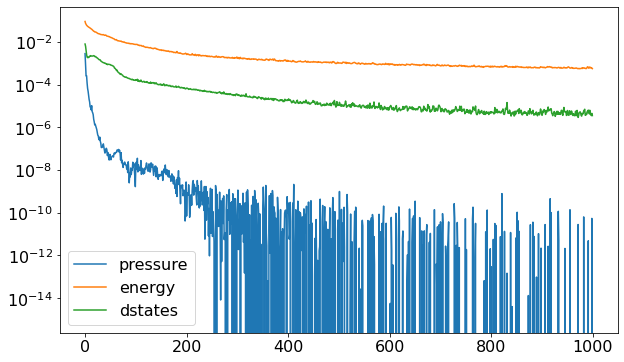

In [68]:
plt.semilogy(history.epoch,history.history['pressure_out_loss'], label='pressure')
plt.semilogy(history.epoch,history.history['energy_out_loss'], label='energy')
plt.semilogy(history.epoch,history.history['dstates_out_loss'], label='dstates')
plt.legend()

In [69]:
A_cluster = model.get_layer('cluster_demand').get_weights()[0]

# Validation data

In [70]:
file = './validation/surrModel_scenarioDB_0.pkl'
with open(file, 'rb') as f:
    validation = pickle.load(f)

In [71]:
output_names.keys()

dict_keys(['pressure', 'tanks', 'power'])

In [72]:
val_demand = validation['input'][input_names['demand']]
val_states = validation['input'][input_names['tanks']]
val_inputs = validation['input'][input_names['pumps']+input_names['valves']]

val_pressure = validation['output'][output_names['pressure']]
val_energy = validation['output'][output_names['power']]

In [73]:
val_states.diff().abs().mean(axis=0)

T3    0.314907
T1    0.274870
T7    0.442034
T6    0.088406
T5    0.342506
T2    0.405590
T4    0.310546
dtype: float32

<AxesSubplot:>

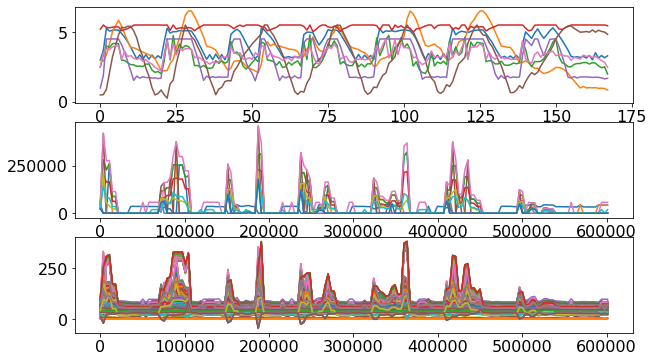

In [74]:
fig,ax = plt.subplots(3,1)
val_states.plot(ax=ax[0], legend=False)
val_energy.plot(ax=ax[1], legend=False)
val_pressure.plot(ax=ax[2], legend=False)

Text(0, 0.5, 'pump power ')

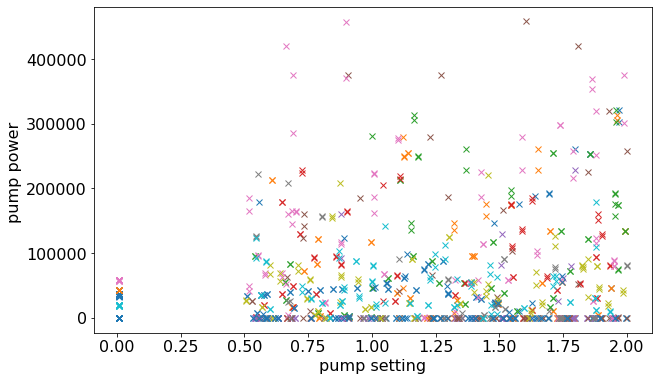

In [86]:
fig, ax = plt.subplots()
ax.plot(
    val_inputs[input_names['pumps']],
    val_energy[output_names['power']],
    'x'
)
ax.set_xlabel('pump setting')
ax.set_ylabel('pump power ')

### Simulation evaluation

In [75]:
from IPython.display import clear_output, display

In [76]:
val_demand_np = val_demand.to_numpy()
val_states_np = val_states.to_numpy()
val_inputs_np = val_inputs.to_numpy()

in_d_scaling = input_scaling['demand'].to_numpy()
in_s_scaling = input_scaling['states'].to_numpy()
in_i_scaling = input_scaling['inputs'].to_numpy()

out_p_scaling = output_scaling['pressure'].to_numpy()
out_e_scaling = output_scaling['energy'].to_numpy()
out_s_scaling = output_scaling['dstates'].to_numpy()

In [77]:
est_states = [val_states_np[[0]]]
est_pressure = []
est_energy = []

for k in range(val_inputs_np.shape[0]-1):
    clear_output(wait=True)
    print(k)
    demand_k = val_demand_np[[k],:]
    states_k = est_states[k]
    inputs_k = val_inputs_np[[k],:]
    
    demand_k_scaled = demand_k/in_d_scaling
    states_k_scaled = states_k/in_s_scaling
    inputs_k_scaled = inputs_k/in_i_scaling

    pressure_scaled, energy_scaled, dstates_scaled = model.predict([demand_k_scaled, states_k_scaled, inputs_k_scaled])
    
    pressure_k = pressure_scaled * out_p_scaling
    energy_k = energy_scaled * out_e_scaling
    states_k_next = states_k + dstates_scaled * out_s_scaling
    
    ### Achtung ENTFERNEN!!!!!!
    #states_k_next = val_states_np[[k+1]]
    
    est_states.append(states_k_next)
    est_energy.append(energy_k)
    est_pressure.append(pressure_k)

est_pressure = np.concatenate(est_pressure,axis=0)
est_energy = np.concatenate(est_energy,axis=0)
est_states = np.concatenate(est_states,axis=0)

166


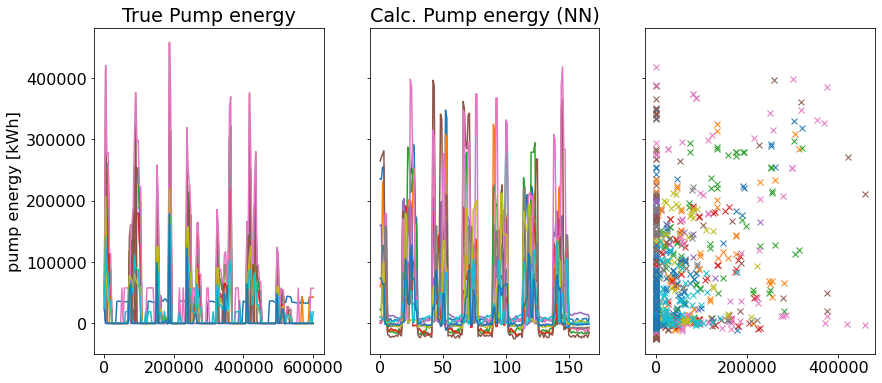

In [80]:
fig,ax = plt.subplots(1,3, figsize=(14,6), sharey=True)
val_energy.plot(legend=False, ax=ax[0])
ax[1].plot(est_energy)
ax[0].set_title('True Pump energy')
ax[1].set_title('Calc. Pump energy (NN)')
ax[0].set_ylabel('pump energy [kWh]')

ax[2].plot(val_energy.to_numpy()[:-1,:], est_energy, 'x')
plt.show()

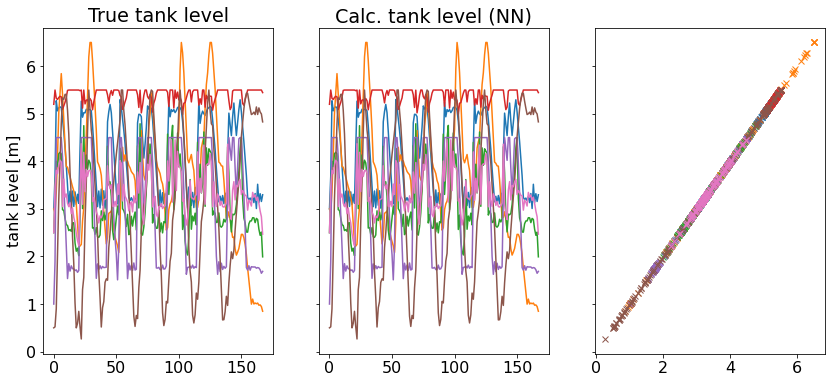

In [57]:
fig,ax = plt.subplots(1,3, figsize=(14,6), sharey=True)
val_states.plot(legend=False, ax=ax[0])
ax[1].plot(est_states)
ax[0].set_title('True tank level')
ax[1].set_title('Calc. tank level (NN)')
ax[0].set_ylabel('tank level [m]')

ax[2].plot(val_states,est_states,'x')
plt.show()

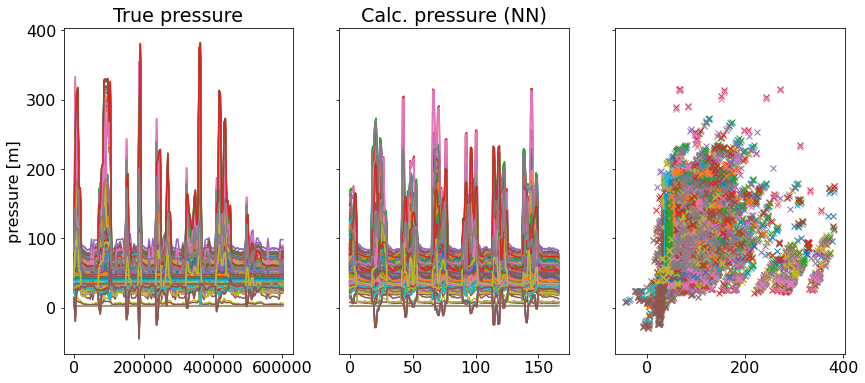

In [58]:
fig,ax = plt.subplots(1,3, figsize=(14,6), sharey=True)
val_pressure.plot(legend=False, ax=ax[0])
ax[1].plot(est_pressure)
ax[0].set_title('True pressure')
ax[1].set_title('Calc. pressure (NN)')
ax[0].set_ylabel('pressure [m]')
ax[2].plot(val_pressure.to_numpy()[:-1,:],est_pressure, 'x')
plt.show()